In [1]:
# Install required libraries
!pip install rasterio fiona

# Import necessary libraries
import os
import zipfile
import rasterio
from rasterio.merge import merge
from rasterio.plot import show
import numpy as np
import matplotlib.pyplot as plt

print("Required libraries installed and imported.")

# Data Download and Extraction

# Configuration
DATA_URL = "https://objectstore.e2enetworks.net/btechtasksampledata/data.zip"
ZIP_FILE_NAME = "data.zip"
INPUT_DIR = "input_tiles"
OUTPUT_FILE = "cloudless_mosaic.tif"

# Download and unzip the data
if not os.path.exists(INPUT_DIR):
    # Use wget to download the file
    !wget {DATA_URL} -O {ZIP_FILE_NAME}

    # Unzip the file
    with zipfile.ZipFile(ZIP_FILE_NAME, 'r') as zip_ref:
        zip_ref.extractall(INPUT_DIR)

    print(f"Data downloaded and extracted to '{INPUT_DIR}/'.")
else:
    print(f"Data directory '{INPUT_DIR}' already exists. Skipping download/extraction.")

# Identify input GeoTIFF files
tile_files = []
for root, dirs, files in os.walk(INPUT_DIR):
    for f in files:
        if f.endswith('.tif'):
            tile_files.append(os.path.join(root, f))

tile_files.sort()
print(f"\nFound {len(tile_files)} input raster tiles.")

Required libraries installed and imported.
Data directory 'input_tiles' already exists. Skipping download/extraction.

Found 10 input raster tiles.


In [2]:
# Validation and Pre-processing

src_files_to_mosaic = []
input_crs = None
input_res = None
properties_consistent = True

print("\n Spatial Validation Report ")
for fpath in tile_files:
    try:
        src = rasterio.open(fpath)
        src_files_to_mosaic.append(src)

        crs = src.crs
        res = src.res

        print(f"File: {os.path.basename(fpath)}")
        print(f"  CRS: {crs}")
        print(f"  Resolution (X, Y): {res}")

        # Check for consistency across all tiles
        if input_crs is None:
            input_crs = crs
            input_res = res
        elif crs != input_crs or res != input_res:
            properties_consistent = False

    except rasterio.RasterioIOError as e:
        print(f"Error opening file {fpath}: {e}")

if not properties_consistent:
    # This step highlights where Reprojection/Resampling would be necessary
    print("\n[WARNING] Inconsistent spatial properties detected. Reprojection/Resampling may be required.")
else:
    print("\n[SUCCESS] All tiles exhibit consistent CRS and Resolution. Proceeding with mosaicing.")


 Spatial Validation Report 
File: 17_20241129_054359_147_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Resolution (X, Y): (0.9356054896919204, 0.9356054896918405)
File: 18_20241129_054358_499_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Resolution (X, Y): (0.9492307103382531, 0.9492307103382034)
File: 19_20241129_054357_865_SN50_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Resolution (X, Y): (0.9413985629369338, 0.9413985629369082)
File: 32_20240716_043003_536_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Resolution (X, Y): (1.2099118177057069, 1.2099118177057238)
File: 33_20240716_043002_901_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Resolution (X, Y): (1.2048776377584478, 1.204877637758516)
File: 34_20240716_043002_264_SN32_L1C_MS_ortho_8bit_ncc_rendered_7_4.tif
  CRS: EPSG:3857
  Resolution (X, Y): (1.1683168794145475, 1.168316879414494)
File: 4_20241124_054616_030_SN50_L1C_MS_ortho_8bit_ncc_render

In [3]:
# Mosaicing Logic

print("\nStarting raster mosaicing process...")

# Use rasterio.merge to combine all open datasets
# out_transform is the GeoTiff transform (affine matrix) for the new mosaic
mosaic, out_transform = merge(src_files_to_mosaic)

print("Mosaicing complete.")

# Get metadata from the first tile and update it for the merged output
out_meta = src_files_to_mosaic[0].meta.copy()

# Determine NoData value (using the value from the first tile)
nodata_value = src_files_to_mosaic[0].nodata if src_files_to_mosaic[0].nodata is not None else 0

# Update metadata with new dimensions, transform, and CRS
out_meta.update({
    "driver": "GTiff",
    "height": mosaic.shape[1],
    "width": mosaic.shape[2],
    "transform": out_transform,
    "crs": input_crs,
    "nodata": nodata_value
})

print("\nOutput Raster Metadata successfully prepared.")

# Close all input file handlers to free resources
for src in src_files_to_mosaic:
    src.close()


Starting raster mosaicing process...
Mosaicing complete.

Output Raster Metadata successfully prepared.


In [4]:
# Export and Georeferencing Validation

# Write the mosaic array to the output GeoTIFF file
with rasterio.open(OUTPUT_FILE, "w", **out_meta) as dest:
    dest.write(mosaic)

print(f"\n[SUCCESS] Final mosaic successfully written to: **{OUTPUT_FILE}**")

# Validation of the output GeoTIFF file properties
with rasterio.open(OUTPUT_FILE) as validation_src:
    print("\n--- Output GeoTIFF Validation ---")
    print(f"Output CRS: {validation_src.crs}")
    print(f"Output Resolution (X, Y): {validation_src.res}")
    print(f"Output Dimensions (H x W): {validation_src.height} x {validation_src.width}")
    print(f"Output NoData Value: {validation_src.nodata}")
    print(f"Output Bounding Box: {validation_src.bounds}")


[SUCCESS] Final mosaic successfully written to: **cloudless_mosaic.tif**

--- Output GeoTIFF Validation ---
Output CRS: EPSG:3857
Output Resolution (X, Y): (0.9356054896919204, 0.9356054896918405)
Output Dimensions (H x W): 27803 x 29088
Output NoData Value: 0.0
Output Bounding Box: BoundingBox(left=8717628.303571457, bottom=3522731.2600538987, right=8744843.196055615, top=3548743.899483801)



DEBUG: Raster dtype: uint8
DEBUG: Original array Min: 0.00
DEBUG: Original array Max: 255.00
DEBUG: NoData Value Used: 0.0
DEBUG: Band Min (2th percentile): 4.00
DEBUG: Band Max (98th percentile): 157.00


/tmp/ipython-input-2319697268.py:38: RuntimeWarning: invalid value encountered in cast
  return np.clip(normalized_array, 0, 255).astype(np.uint8)


DEBUG: Band Min (2th percentile): 5.00
DEBUG: Band Max (98th percentile): 156.00
DEBUG: Band Min (2th percentile): 5.00
DEBUG: Band Max (98th percentile): 134.00


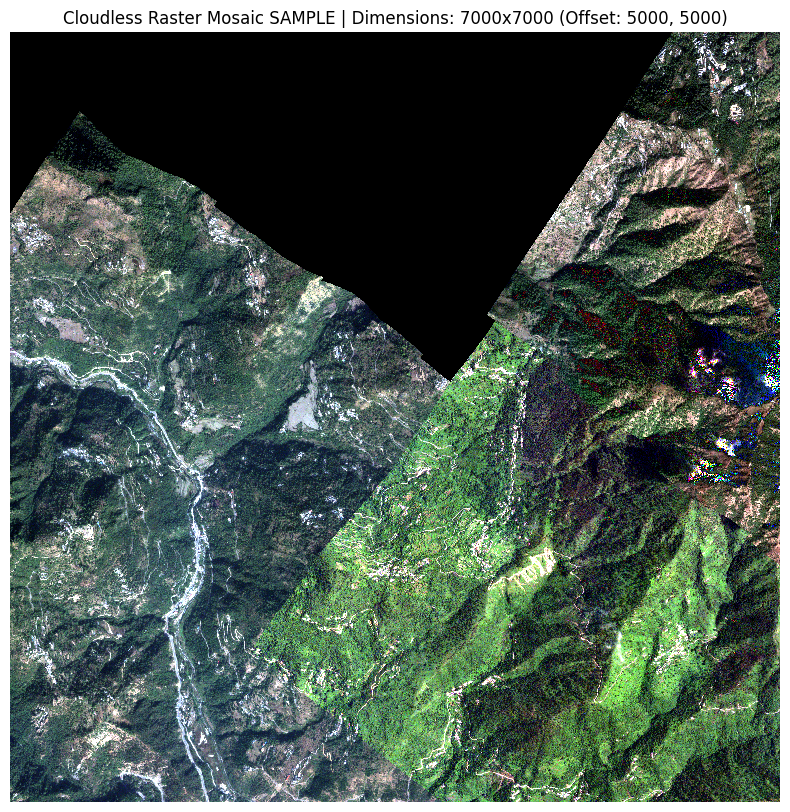

2430

In [18]:
# --- REVISED CODE BLOCK WITH DIAGNOSTICS ---
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import gc

# --- CONFIGURATION ---
OUTPUT_FILE = "cloudless_mosaic.tif"
SAMPLE_SIZE = 7000
# Keep offset at 0, 0 for initial check
OFFSET_X = 5000
OFFSET_Y = 5000
# --- END CONFIGURATION ---

# Function for data normalization using Percentile Clipping
def normalize(array, lower_percentile=2, upper_percentile=98):
    """Normalize array values to 0-255 using percentile clipping for visualization."""
    array_clean = array[~np.isnan(array)]

    if array_clean.size == 0:
        return np.zeros_like(array, dtype=np.uint8)

    # Calculate min and max based on percentiles (removes outliers)
    array_min = np.percentile(array_clean, lower_percentile)
    array_max = np.percentile(array_clean, upper_percentile)

    # --- DIAGNOSTICS: Check Percentile Range ---
    print(f"DEBUG: Band Min ({lower_percentile}th percentile): {array_min:.2f}")
    print(f"DEBUG: Band Max ({upper_percentile}th percentile): {array_max:.2f}")
    # ------------------------------------------

    if array_max <= array_min:
        return np.zeros_like(array, dtype=np.uint8)

    clipped_array = np.clip(array, array_min, array_max)
    normalized_array = ((clipped_array - array_min) / (array_max - array_min)) * 255

    return np.clip(normalized_array, 0, 255).astype(np.uint8)

# Read ONLY A SAMPLE of the data
with rasterio.open(OUTPUT_FILE) as src:
    nodata_value = src.nodata
    if nodata_value is None:
        # If your data is, for example, 16-bit, -9999 is a common background.
        nodata_value = -9999

    # 1. Define the sampling window
    width = min(SAMPLE_SIZE, src.width - OFFSET_X)
    height = min(SAMPLE_SIZE, src.height - OFFSET_Y)
    window = rasterio.windows.Window(OFFSET_X, OFFSET_Y, width, height)

    # 2. Read only the data within the window (read as its native dtype first)
    final_mosaic_data = src.read(window=window)

    # --- DIAGNOSTICS: Check Native Data Range ---
    print(f"\nDEBUG: Raster dtype: {final_mosaic_data.dtype}")
    print(f"DEBUG: Original array Min: {np.nanmin(final_mosaic_data):.2f}")
    print(f"DEBUG: Original array Max: {np.nanmax(final_mosaic_data):.2f}")
    print(f"DEBUG: NoData Value Used: {nodata_value}")
    # ------------------------------------------

    # Convert to float and transpose AFTER reading to save memory
    final_mosaic_data_float = final_mosaic_data.astype(float)
    final_mosaic_data_t = final_mosaic_data_float.transpose(1, 2, 0)

# Handle NoData pixels for clear plotting (set NoData to NaN)
final_mosaic_data_t[final_mosaic_data_t == nodata_value] = np.nan

# --- Processing (Visualization) ---
if final_mosaic_data_t.shape[2] >= 3:
    # We will normalize Red, Green, and Blue bands
    mosaic_rgb = np.stack([
        normalize(final_mosaic_data_t[:, :, 0]), # Red Band
        normalize(final_mosaic_data_t[:, :, 1]), # Green Band
        normalize(final_mosaic_data_t[:, :, 2]) # Blue Band
    ], axis=2)
else:
    # Single-band (grayscale) visualization
    mosaic_rgb = normalize(final_mosaic_data_t[:, :, 0])
# --- End Processing ---

# Visualization (Displaying the image...)
plt.figure(figsize=(10, 10))
plt.title(f"Cloudless Raster Mosaic SAMPLE | Dimensions: {width}x{height} (Offset: {OFFSET_X}, {OFFSET_Y})")
plt.imshow(mosaic_rgb, interpolation='nearest')
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.axis('off')
plt.show()

# 🗑️ CRITICAL STEP: Explicitly clear large variables
del final_mosaic_data
del final_mosaic_data_float
del final_mosaic_data_t
del mosaic_rgb
gc.collect()
# ----------------------------------------------------

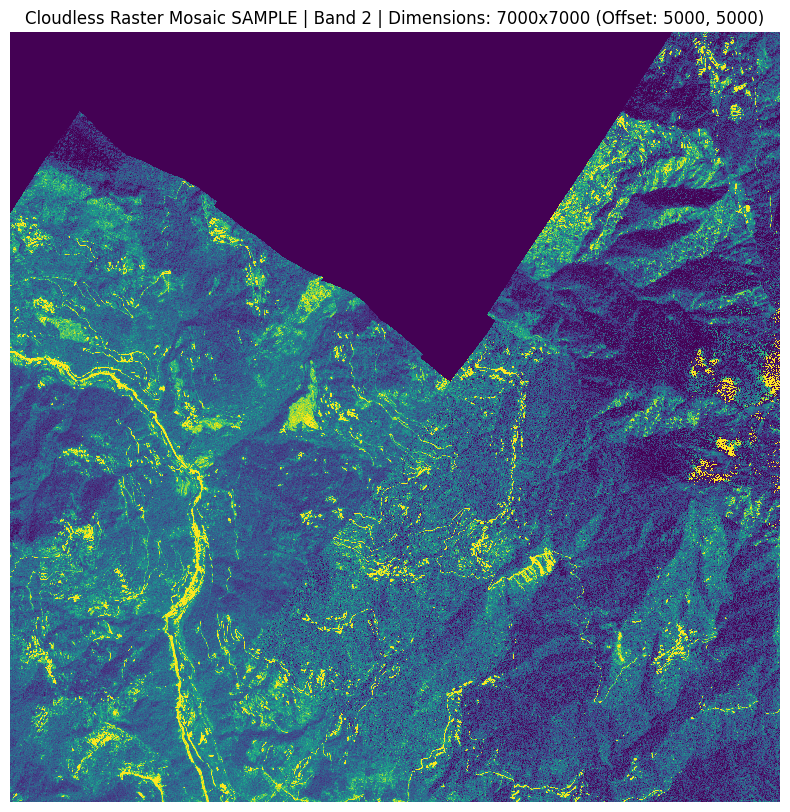

2427

In [16]:
# --- REVISED CODE BLOCK ---
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import gc

# --- CONFIGURATION (Adjusted Offset) ---
OUTPUT_FILE = "cloudless_mosaic.tif"
SAMPLE_SIZE = 7000 # Increased sample size to see more of the image
# Changed offset to sample a more central region of the mosaic
OFFSET_X = 5000
OFFSET_Y = 5000

# New: Specify the band to visualize (0-indexed). Set to None for RGB if available.
TARGET_BAND = 2 # Example: visualize the first band (band 0)
# --- END CONFIGURATION ---

# Function for data normalization using Percentile Clipping for better contrast
def normalize(array, lower_percentile=2, upper_percentile=98):
    """Normalize array values to 0-255 using percentile clipping for visualization."""
    array_clean = array[~np.isnan(array)]

    if array_clean.size == 0:
        return np.zeros_like(array, dtype=np.uint8)

    # Calculate min and max based on percentiles (removes outliers)
    array_min = np.percentile(array_clean, lower_percentile)
    array_max = np.percentile(array_clean, upper_percentile)

    # Avoid division by zero
    if array_max <= array_min:
        return np.zeros_like(array, dtype=np.uint8)

    # Clip the data to the calculated range before scaling
    clipped_array = np.clip(array, array_min, array_max)

    # Scale to 0-255
    normalized_array = ((clipped_array - array_min) / (array_max - array_min)) * 255

    # Explicitly replace NaNs with 0 before casting to uint8 to prevent RuntimeWarning
    normalized_array[np.isnan(normalized_array)] = 0

    return np.clip(normalized_array, 0, 255).astype(np.uint8)

# Read ONLY A SAMPLE of the data
with rasterio.open(OUTPUT_FILE) as src:
    nodata_value = src.nodata
    if nodata_value is None:
        nodata_value = -9999

    # 1. Define the sampling window
    width = min(SAMPLE_SIZE, src.width - OFFSET_X)
    height = min(SAMPLE_SIZE, src.height - OFFSET_Y)

    window = rasterio.windows.Window(OFFSET_X, OFFSET_Y, width, height)

    # 2. Read only the data within the window
    # Read the data and ensure it's loaded as float to handle NaN conversion
    final_mosaic_data = src.read(window=window).astype(float)

# --- Processing ---
final_mosaic_data_t = final_mosaic_data.transpose(1, 2, 0)

# Handle NoData pixels for clear plotting (set NoData to NaN)
# Ensure this happens AFTER loading as float
final_mosaic_data_t[final_mosaic_data_t == nodata_value] = np.nan

if TARGET_BAND is not None:
    # Visualize a specific band in grayscale
    if TARGET_BAND < final_mosaic_data_t.shape[2]:
        mosaic_rgb = normalize(final_mosaic_data_t[:, :, TARGET_BAND])
        plot_title = f"Cloudless Raster Mosaic SAMPLE | Band {TARGET_BAND} | Dimensions: {width}x{height} (Offset: {OFFSET_X}, {OFFSET_Y})"
    else:
        print(f"Warning: TARGET_BAND {TARGET_BAND} is out of range. Defaulting to Band 0.")
        mosaic_rgb = normalize(final_mosaic_data_t[:, :, 0])
        plot_title = f"Cloudless Raster Mosaic SAMPLE | Band 0 (Default) | Dimensions: {width}x{height} (Offset: {OFFSET_X}, {OFFSET_Y})"
elif final_mosaic_data_t.shape[2] >= 3:
    # Use the improved normalization for RGB
    mosaic_rgb = np.stack([
        normalize(final_mosaic_data_t[:, :, 0]), # Red Band
        normalize(final_mosaic_data_t[:, :, 1]), # Green Band
        normalize(final_mosaic_data_t[:, :, 2]) # Blue Band
    ], axis=2)
    plot_title = f"Cloudless Raster Mosaic SAMPLE | RGB | Dimensions: {width}x{height} (Offset: {OFFSET_X}, {OFFSET_Y})"
else:
    # Single-band (grayscale) visualization if less than 3 bands and TARGET_BAND is None
    mosaic_rgb = normalize(final_mosaic_data_t[:, :, 0])
    plot_title = f"Cloudless Raster Mosaic SAMPLE | Band 0 | Dimensions: {width}x{height} (Offset: {OFFSET_X}, {OFFSET_Y})"
# --- End Processing ---

# Visualization
plt.figure(figsize=(10, 10))
plt.title(plot_title)
plt.imshow(mosaic_rgb, interpolation='nearest')
plt.xlabel("Pixel Column")
plt.ylabel("Pixel Row")
plt.axis('off')
plt.show()

# ⛭️ CRITICAL STEP: Explicitly clear large variables
del final_mosaic_data
del final_mosaic_data_t
del mosaic_rgb
gc.collect()